In [77]:
import numpy as np
import pandas as pd

In [78]:
def getFeatureMatrix(rawDataMatrix, windowLength, windowOverlap):
    rms = lambda sig: np.sqrt(np.mean(sig**2))
    nChannels,nSamples = rawDataMatrix.shape    
    I = int(np.floor(nSamples/(windowLength-windowOverlap)))
    featMatrix = np.zeros([nChannels, I])
    for channel in range(nChannels):
        for i in range (I):
            wdwStrtIdx=i*(windowLength-windowOverlap)
            sigWin = rawDataMatrix[channel][wdwStrtIdx:(wdwStrtIdx+windowLength-1)] 
            featMatrix[channel, i] = rms(sigWin)
    featMatrixData = np.array(featMatrix)
    return featMatrixData

In [79]:
import os

Fs = 500
windowLength = int(np.floor(0.1*Fs))  #160ms
windowOverlap =  int(np.floor(50/100 * windowLength))

train_features = np.zeros([0,8])
train_labels = np.zeros([0])
test_features = np.zeros([0,8])
test_labels = np.zeros([0])
for shift in range(0,5): 
    for files in sorted(os.listdir(f'Subject_3/Shift_{shift}/')):
        _, class_,_, rep_ = files.split('_')
        if int(class_) in [1,2,3]:
            df = pd.read_csv(f'Subject_3/Shift_{shift}/{files}',skiprows=0,sep=' ',header=None)
            data_arr = np.stack([np.array(df.T[i::8]).T.flatten().astype('float32') for i in range (8)])
            data_arr -= 121
            data_arr /= 255.0
            feaData = getFeatureMatrix(data_arr, windowLength, windowOverlap)
            
            if not class_.startswith('9'):
                rms_feature = feaData.sum(0)
                baseline = 2*rms_feature[-50:].mean()
                start_ = np.argmax(rms_feature[::1]>baseline)
                end_  = -np.argmax(rms_feature[::-1]>baseline)
                feaData = feaData.T[start_:end_]
            else:
                feaData = feaData.T
            if rep_.startswith('2'):
                test_features = np.concatenate([test_features,feaData])
                test_labels = np.concatenate([test_labels,np.ones_like(feaData)[:,0]*int(class_)-1])
            else:
                train_features = np.concatenate([train_features,feaData])
                train_labels = np.concatenate([train_labels,np.ones_like(feaData)[:,0]*int(class_)-1])

print(train_features)
print(train_labels) 
print(test_features)
print(test_labels)

[[0.00598156 0.00485168 0.0475498  ... 0.00543157 0.00326664 0.00280112]
 [0.00522542 0.00403983 0.04086565 ... 0.00516501 0.00316911 0.00274453]
 [0.00510388 0.00230986 0.03773932 ... 0.00738986 0.00582202 0.00321824]
 ...
 [0.00960584 0.00291101 0.00316911 ... 0.01998045 0.00780302 0.02171185]
 [0.00901595 0.00321824 0.0031192  ... 0.00906802 0.0063134  0.02011353]
 [0.00768141 0.00262768 0.00306847 ... 0.00813773 0.00403983 0.01856363]]
[0. 0. 0. ... 2. 2. 2.]
[[0.00568565 0.0333792  0.07218635 ... 0.00683841 0.00371611 0.0031192 ]
 [0.00590233 0.03841111 0.07555345 ... 0.00590233 0.00426654 0.00358718]
 [0.00623839 0.02138413 0.04891305 ... 0.0069522  0.00510388 0.00358718]
 ...
 [0.01432685 0.00481923 0.00396138 ... 0.03839068 0.00866085 0.02116283]
 [0.00704191 0.00216974 0.0030169  ... 0.01339861 0.00488392 0.01283635]
 [0.00794255 0.0031192  0.00296443 ... 0.00761987 0.00721798 0.01396071]]
[0. 0. 0. ... 2. 2. 2.]


In [80]:
print(type(train_features))
print(type(train_labels))
print(train_features.shape)

print(test_features.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4269, 8)
(4029, 8)


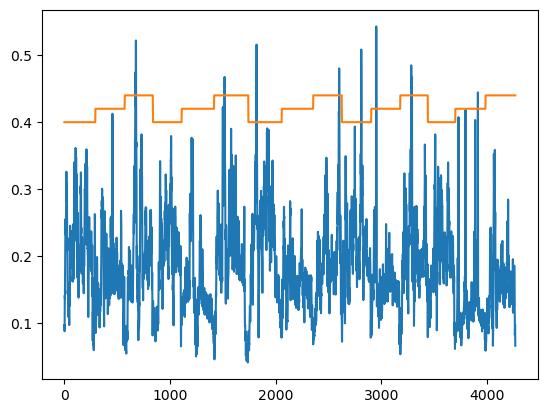

In [81]:
import matplotlib.pyplot as plt
plt.plot(train_features.sum(1))
plt.plot(train_labels/50+ 0.4)

In [82]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(penalty='l2', C=100).fit(train_features, train_labels)
reg.score(train_features, train_labels)#, reg.score(test_features, test_labels)

0.8582806277816819

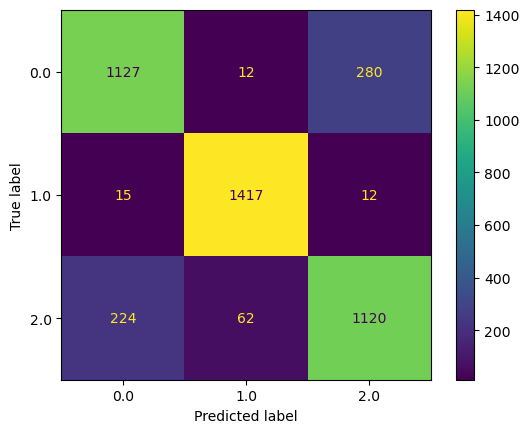

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(train_labels, reg.predict(train_features)),
                            display_labels=reg.classes_)
disp.plot()

In [84]:
from joblib import dump, load
dump(reg, 'LogisticRegression1.joblib') 

['LogisticRegression1.joblib']

In [85]:
accuracy_list = []
accuracy_list = [reg.score(test_features,test_labels)]


In [86]:
accuracy_list

[0.8535616778356913]